# XGBoost Training and Tuning
## Using Original Imbalanced Data with scale_pos_weight

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

from xgboost import XGBClassifier
from sklearn.model_selection import ParameterSampler

try:
    from tqdm.auto import tqdm
except ImportError:
    import sys
    !{sys.executable} -m pip install tqdm --quiet
    from tqdm.auto import tqdm

import joblib
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries imported")
print(f"Training started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Libraries imported
Training started: 2026-01-02 01:56:15


## 2. Load Original Data (Not SMOTE)

In [2]:
print("="*70)
print("LOADING ORIGINAL DATA")
print("="*70)

# Load ORIGINAL HealthInspections.csv (not SMOTE version)
df = pd.read_csv('/Users/deepaktalwar/PyCharmMiscProject/HealthInspectionsEncoded.csv')

print(f"\nOriginal data: {df.shape}")
print(f"\nTarget distribution:")
print(df['failFlag'].value_counts())
print(f"\nPercentages:")
print(df['failFlag'].value_counts(normalize=True))

# Remove violation_count (data leakage)
if 'violation_count' in df.columns:
    print(f"\n Removing violation_count (data leakage)")
    df = df.drop('violation_count', axis=1)
    print(f"✓ Removed! New shape: {df.shape}")

LOADING ORIGINAL DATA

Original data: (32097, 38)

Target distribution:
failFlag
0    29822
1     2275
Name: count, dtype: int64

Percentages:
failFlag
0    0.929121
1    0.070879
Name: proportion, dtype: float64

 Removing violation_count (data leakage)
✓ Removed! New shape: (32097, 37)


## 3. Train/Validation Split

In [3]:
print("\n" + "="*70)
print("SPLITTING DATA")
print("="*70)

# Separate features and target
X = df.drop('failFlag', axis=1)
y = df['failFlag']

# Split (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

print(f"\nTraining target distribution:")
print(f"  Pass (0): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"  Fail (1): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

print(f"\nValidation target distribution:")
print(f"  Pass (0): {(y_val==0).sum():,} ({(y_val==0).sum()/len(y_val)*100:.1f}%)")
print(f"  Fail (1): {(y_val==1).sum():,} ({(y_val==1).sum()/len(y_val)*100:.1f}%)")


SPLITTING DATA

Training set: (25677, 36)
Validation set: (6420, 36)

Training target distribution:
  Pass (0): 23,857 (92.9%)
  Fail (1): 1,820 (7.1%)

Validation target distribution:
  Pass (0): 5,965 (92.9%)
  Fail (1): 455 (7.1%)


## 4. Scale Features

In [6]:
print("\n" + "="*70)
print("SCALING FEATURES")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\n✓ Features scaled using StandardScaler")
print(f"  Fitted on training data")
print(f"  Applied to validation data")

## 5. Calculate scale_pos_weight

In [7]:
print("\n" + "="*70)
print("CALCULATING scale_pos_weight")
print("="*70)

# Calculate ratio of negative to positive class
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"\nClass imbalance ratio: {scale_pos_weight:.2f}:1 (Pass:Fail)")
print(f"scale_pos_weight = {scale_pos_weight:.4f}")
print(f"\nThis tells XGBoost to weight Fail class {scale_pos_weight:.1f}x more than Pass class")


CALCULATING scale_pos_weight

Class imbalance ratio: 13.11:1 (Pass:Fail)
scale_pos_weight = 13.1082

This tells XGBoost to weight Fail class 13.1x more than Pass class


## 6. Baseline Model (No Tuning)

In [10]:
print("\n" + "="*70)
print("BASELINE XGBOOST MODEL")
print("="*70)

# Simple XGBoost with default params + scale_pos_weight
xgb_baseline = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("\nTraining baseline model...")
xgb_baseline.fit(X_train_scaled, y_train)

# Validate
y_pred_proba = xgb_baseline.predict_proba(X_val_scaled)[:, 1]
baseline_roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f"\n✓ Baseline Validation ROC-AUC: {baseline_roc_auc:.4f}")

if baseline_roc_auc > 0.75:
    print("  ✅ Good baseline! Tuning should improve this further.")
elif baseline_roc_auc > 0.70:
    print("  ✓ Acceptable baseline. Tuning needed.")
else:
    print("  ⚠️  Weak baseline. Features may not be very predictive.")


BASELINE XGBOOST MODEL

Training baseline model...

 Baseline Validation ROC-AUC: 0.8089


## 7. Hyperparameter Tuning

In [ ]:
print("\n" + "="*70)
print("HYPERPARAMETER TUNING - XGBOOST")
print("="*70)

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

print("\nParameter distributions:")
for param, values in param_dist.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_dist.values()])
n_iter = 50

print(f"\nTotal possible combinations: {total_combinations}")
print(f"Testing {n_iter} random combinations")
print(f"Estimated time: 5-10 minutes...\n")

# Sample parameters
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# Progress tracking
pbar = tqdm(total=n_iter, desc="Tuning XGBoost",
            bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}] {postfix}')

best_score = 0
best_params = None
cv_results = []

print("Starting randomized search...\n")

for params in param_list:
    # Create model with these parameters
    xgb = XGBClassifier(
        **params,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    # Cross-validate
    scores = cross_val_score(xgb, X_train_scaled, y_train, 
                             cv=5, scoring='roc_auc', n_jobs=-1)
    mean_score = scores.mean()
    
    cv_results.append({
        'params': params,
        'cv_score': mean_score,
        'cv_std': scores.std()
    })
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
    
    # Update progress
    pbar.update(1)
    pbar.set_postfix({'best_cv_score': f'{best_score:.4f}'})

pbar.close()

print("\n" + "="*70)
print("✓ Tuning complete!")
print("="*70)
print(f"\nBest CV ROC-AUC: {best_score:.4f}")
print(f"\nBest parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

## 8. Train Final Model with Best Parameters

In [ ]:
print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

# Create final model with best parameters
xgb_tuned = XGBClassifier(
    **best_params,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("\nTraining final model with best parameters...")
xgb_tuned.fit(X_train_scaled, y_train)

print("✓ Training complete!")

## 9. Validate on Validation Set

In [ ]:
print("\n" + "="*70)
print("VALIDATION RESULTS")
print("="*70)

# Predictions
y_pred_proba = xgb_tuned.predict_proba(X_val_scaled)[:, 1]
y_pred = xgb_tuned.predict(X_val_scaled)

# Metrics
val_accuracy = accuracy_score(y_val, y_pred)
val_precision = precision_score(y_val, y_pred, zero_division=0)
val_recall = recall_score(y_val, y_pred, zero_division=0)
val_f1 = f1_score(y_val, y_pred, zero_division=0)
val_roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f"\nValidation Metrics:")
print(f"  ROC-AUC:   {val_roc_auc:.4f}")
print(f"  Accuracy:  {val_accuracy:.4f}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall:    {val_recall:.4f}")
print(f"  F1-Score:  {val_f1:.4f}")

# Compare to baseline
print(f"\nImprovement over baseline:")
print(f"  Baseline ROC-AUC: {baseline_roc_auc:.4f}")
print(f"  Tuned ROC-AUC:    {val_roc_auc:.4f}")
print(f"  Improvement:      {val_roc_auc - baseline_roc_auc:+.4f} ({(val_roc_auc - baseline_roc_auc)/baseline_roc_auc*100:+.1f}%)")

# Generalization check
gen_gap = val_roc_auc - best_score
print(f"\nGeneralization:")
print(f"  CV ROC-AUC:         {best_score:.4f}")
print(f"  Validation ROC-AUC: {val_roc_auc:.4f}")
print(f"  Gap:                {gen_gap:+.4f} ({gen_gap/best_score*100:+.1f}%)")

if abs(gen_gap) < 0.03:
    print(f"  ✓ Excellent generalization!")
elif abs(gen_gap) < 0.05:
    print(f"  ✓ Good generalization")
else:
    print(f"  ⚠️  Check for overfitting")

# Classification report
print(f"\n{'-'*70}")
print("Classification Report:")
print(f"{'-'*70}")
print(classification_report(y_val, y_pred, target_names=['Pass', 'Fail']))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(f"\n{'-'*70}")
print("Confusion Matrix:")
print(f"{'-'*70}")
print(f"              Predicted")
print(f"           Pass    Fail")
print(f"Pass       {cm[0,0]:<6} {cm[0,1]:<6}")
print(f"Fail       {cm[1,0]:<6} {cm[1,1]:<6}")

## 10. Save Model

In [ ]:
print("\n" + "="*70)
print("SAVING MODEL")
print("="*70)

# Create model package
model_package = {
    'model': xgb_tuned,
    'model_name': 'XGBoost (Tuned with scale_pos_weight)',
    'scaler': scaler,
    'feature_names': X_train.columns.tolist(),
    'best_params': best_params,
    'scale_pos_weight': scale_pos_weight,
    'removed_features': ['violation_count'],
    'training_performance': {
        'cv_roc_auc': best_score,
        'baseline_roc_auc': baseline_roc_auc
    },
    'validation_performance': {
        'roc_auc': val_roc_auc,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'notes': 'Trained on original imbalanced data with scale_pos_weight, no SMOTE'
}

# Save
model_path = '/Users/deepaktalwar/PyCharmMiscProject/outputs2/xgboost_tuned_scaleweight.pkl'
joblib.dump(model_package, model_path)

print(f"\n✓ Model saved: {model_path}")
print(f"\nModel package includes:")
print(f"  • Trained XGBoost model")
print(f"  • StandardScaler")
print(f"  • Feature names ({len(X_train.columns)})")
print(f"  • Best hyperparameters")
print(f"  • Training performance (CV ROC-AUC: {best_score:.4f})")
print(f"  • Validation performance (ROC-AUC: {val_roc_auc:.4f})")
print(f"  • scale_pos_weight: {scale_pos_weight:.4f}")

## 11. Visualization


CREATING VISUALIZATIONS


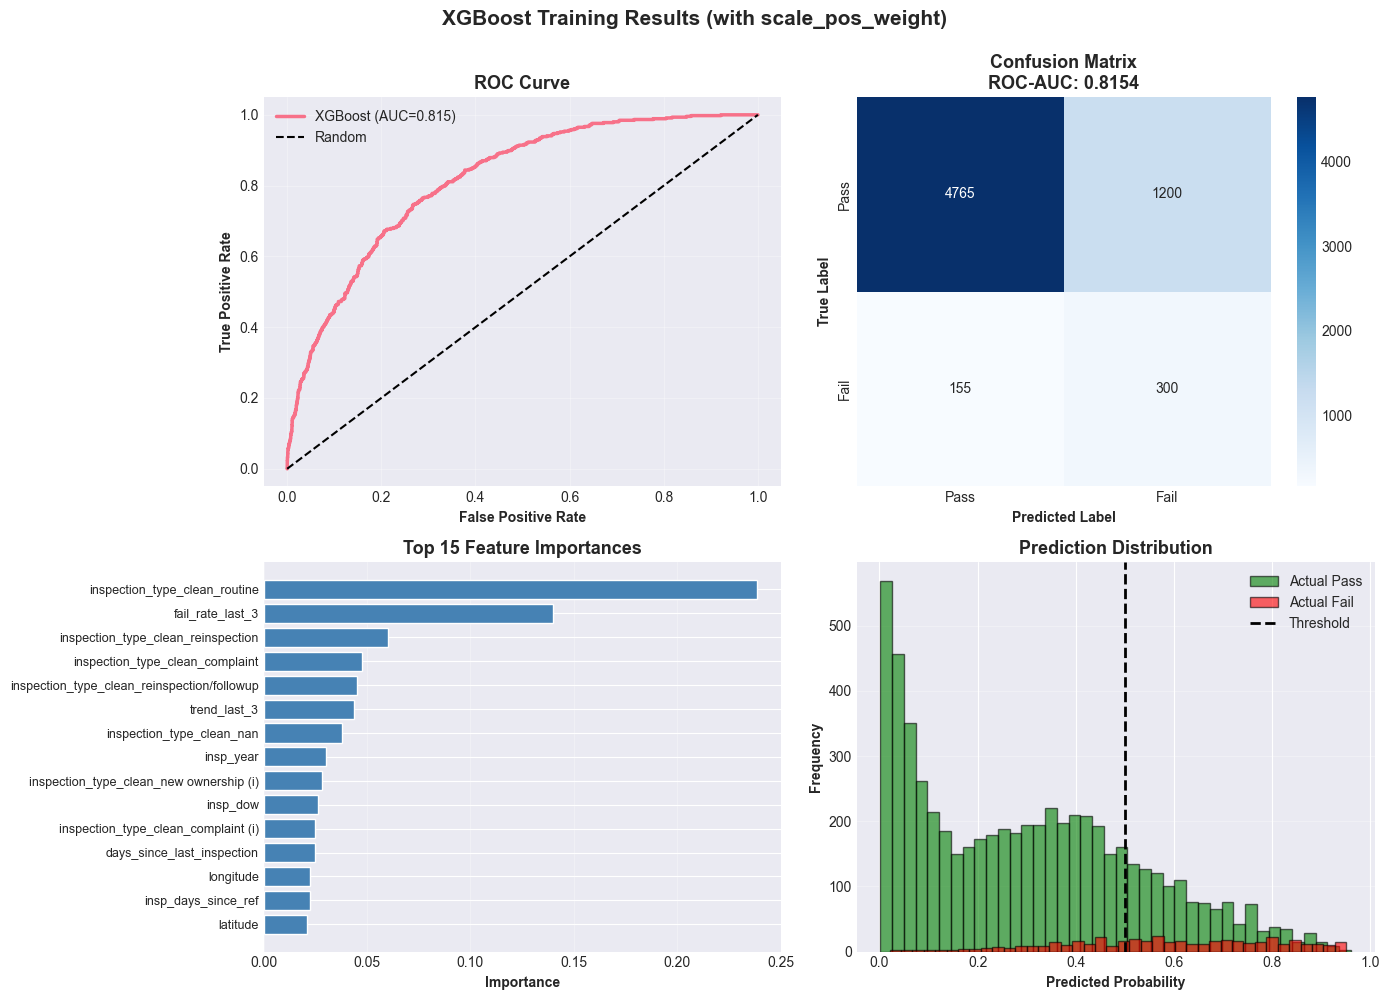


✓ Visualization saved: XGBoost_Training_Results.png


In [12]:
print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
axes[0, 0].plot(fpr, tpr, linewidth=2.5, label=f'XGBoost (AUC={val_roc_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontweight='bold')
axes[0, 0].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'])
axes[0, 1].set_title(f'Confusion Matrix\nROC-AUC: {val_roc_auc:.4f}',
                     fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontweight='bold')
axes[0, 1].set_xlabel('Predicted Label', fontweight='bold')

# 3. Feature Importance
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)[-15:]
feature_names = X_train.columns.tolist()

axes[1, 0].barh(range(len(indices)), importances[indices], color='steelblue')
axes[1, 0].set_yticks(range(len(indices)))
axes[1, 0].set_yticklabels([feature_names[i] for i in indices], fontsize=9)
axes[1, 0].set_xlabel('Importance', fontweight='bold')
axes[1, 0].set_title('Top 15 Feature Importances', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Prediction Distribution
axes[1, 1].hist(y_pred_proba[y_val==0], bins=40, alpha=0.6,
                label='Actual Pass', color='green', edgecolor='black')
axes[1, 1].hist(y_pred_proba[y_val==1], bins=40, alpha=0.6,
                label='Actual Fail', color='red', edgecolor='black')
axes[1, 1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1, 1].set_xlabel('Predicted Probability', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('Prediction Distribution', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('XGBoost Training Results (with scale_pos_weight)',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/Users/deepaktalwar/PyCharmMiscProject/Xgboost result/XGBoost_Training_Results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: XGBoost_Training_Results.png")

In [4]:
# Inspect the saved XGBoost model package used by the backend

import joblib

from pprint import pprint



# Path to the model package currently used in the FastAPI backend

model_path = r"C:/Users/lkneh/HealthScore-Predictor/notebooks/Model/random_forest_multiclass.pkl"



model_package = joblib.load(model_path)

print("Type of loaded object:", type(model_package))



if isinstance(model_package, dict):

    print("\nTop-level keys in model_package:\n")

    pprint(list(model_package.keys()))



    # Optionally peek into some nested sections

    if "training_performance" in model_package:

        print("\ntraining_performance:")

        pprint(model_package["training_performance"])

    if "validation_performance" in model_package:

        print("\nvalidation_performance:")

        pprint(model_package["validation_performance"])

else:

    print("\nLoaded object is not a dict; it may be a raw estimator.")


Type of loaded object: <class 'xgboost.sklearn.XGBClassifier'>

Loaded object is not a dict; it may be a raw estimator.


c:\Program Files\Python311\Lib\pickle.py:1718: UserWarning: [22:46:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [5]:
# Inspect the multiclass XGBoost model package

import joblib

from pprint import pprint



model_path = r"C:\\Users\\lkneh\\HealthScore-Predictor\\notebooks\\Model\\xgboost_multiclass_model.pkl"



model_obj = joblib.load(model_path)

print("Type of loaded object:", type(model_obj))



if isinstance(model_obj, dict):

    print("\nTop-level keys in model package:\n")

    pprint(list(model_obj.keys()))



    if "model" in model_obj:

        print("\nInner estimator type:", type(model_obj["model"]))

    if "training_performance" in model_obj:

        print("\ntraining_performance:")

        pprint(model_obj["training_performance"])

    if "validation_performance" in model_obj:

        print("\nvalidation_performance:")

        pprint(model_obj["validation_performance"])

else:

    print("\nLoaded object is not a dict; it may be a raw estimator.")


Type of loaded object: <class 'dict'>

Top-level keys in model package:

['model',
 'model_name',
 'scaler',
 'feature_names',
 'best_params',
 'class_weights',
 'training_performance',
 'validation_performance',
 'training_date',
 'dataset_info']

Inner estimator type: <class 'xgboost.sklearn.XGBClassifier'>

training_performance:
{'baseline_accuracy': 0.9515304175253797,
 'cv_accuracy': np.float64(0.9525981310419217)}

validation_performance:
{'accuracy': 0.9514540874742387,
 'f1_score': 0.9476740396198238,
 'precision': 0.9530917715204942,
 'recall': 0.9514540874742387}


In [7]:
# Summarize stored validation metrics for saved model packages (no dataset needed)

import joblib

from pprint import pprint



models_to_check = [

    {

        "name": "Random Forest multiclass",

        "path": r"C:/Users/lkneh/HealthScore-Predictor/notebooks/Model/random_forest_multiclass.pkl",

    },

    {

        "name": "XGBoost multiclass",

        "path": r"C:/Users/lkneh/HealthScore-Predictor/notebooks/Model/xgboost_multiclass_model.pkl",

    },

    {

        "name": "Binary XGBoost (failFlag)",

        "path": r"C:/Users/lkneh/HealthScore-Predictor/notebooks/Model/xgboost_tuned_scaleweight.pkl",

    },

]



for spec in models_to_check:

    name = spec["name"]

    path = spec["path"]

    print("=" * 80)

    print(f"Model: {name}")

    print(f"Path:  {path}")



    try:

        obj = joblib.load(path)

    except Exception as e:

        print(f"  !! Could not load model: {e}")

        continue



    print("  Type of loaded object:", type(obj))



    if isinstance(obj, dict):

        keys = list(obj.keys())

        print("  Top-level keys:")

        print("   ", keys)



        if "training_performance" in obj:

            print("\n  training_performance:")

            pprint(obj["training_performance"])



        if "validation_performance" in obj:

            print("\n  validation_performance:")

            pprint(obj["validation_performance"])



            if isinstance(obj["validation_performance"], dict) and "roc_auc" in obj["validation_performance"]:

                print(f"\n  Stored ROC-AUC: {obj['validation_performance']['roc_auc']:.4f}")

        else:

            print("\n  No validation_performance found in this package.")

    else:

        print("  Loaded object is not a dict (likely a raw estimator); no stored metrics to print.")



print("\nDone.")

Model: Random Forest multiclass
Path:  C:/Users/lkneh/HealthScore-Predictor/notebooks/Model/random_forest_multiclass.pkl
  Type of loaded object: <class 'xgboost.sklearn.XGBClassifier'>
  Loaded object is not a dict (likely a raw estimator); no stored metrics to print.
Model: XGBoost multiclass
Path:  C:/Users/lkneh/HealthScore-Predictor/notebooks/Model/xgboost_multiclass_model.pkl
  Type of loaded object: <class 'dict'>
  Top-level keys:
    ['model', 'model_name', 'scaler', 'feature_names', 'best_params', 'class_weights', 'training_performance', 'validation_performance', 'training_date', 'dataset_info']

  training_performance:
{'baseline_accuracy': 0.9515304175253797,
 'cv_accuracy': np.float64(0.9525981310419217)}

  validation_performance:
{'accuracy': 0.9514540874742387,
 'f1_score': 0.9476740396198238,
 'precision': 0.9530917715204942,
 'recall': 0.9514540874742387}
Model: Binary XGBoost (failFlag)
Path:  C:/Users/lkneh/HealthScore-Predictor/notebooks/Model/xgboost_tuned_scalewe